In [348]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
from scipy.stats import chi2_contingency
from statsmodels.stats import power as smp

In [349]:
sns.set_style('darkgrid')

In [350]:
df = pd.read_csv('результаты А_B - cookie_cats 2.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [352]:
version = df['version'].unique()
sorted(version)

['gate_30', 'gate_40']

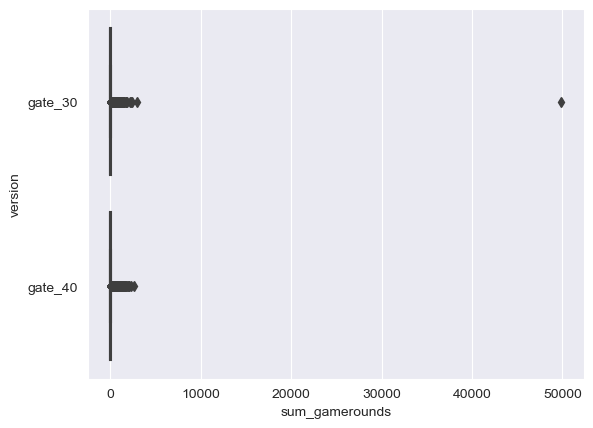

In [353]:
sns.boxplot(data = df, x = df['sum_gamerounds'], y = df['version']);

In [354]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


In [355]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [356]:
# Значителные выбросы свидетельствуют скорее всего о наличии ботов в игре
# Очистим от выбросов
df_clear = df[df['sum_gamerounds'] < df['sum_gamerounds'].quantile(0.75)]

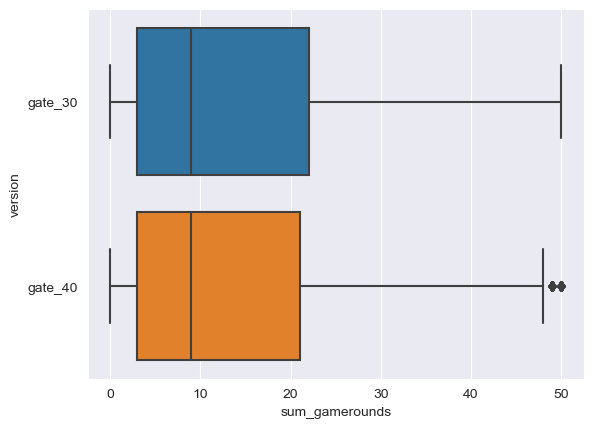

In [357]:
sns.boxplot(data = df_clear, x = df_clear['sum_gamerounds'], y = df_clear['version']);

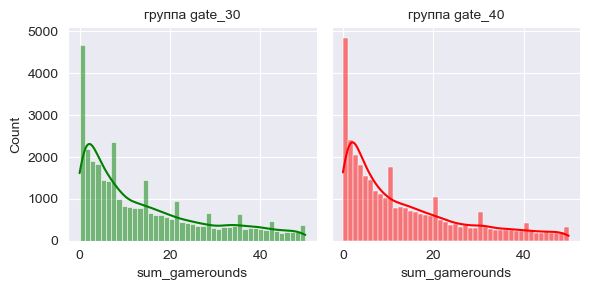

In [358]:
d = {'color': ['g', 'r']}
g = sns.FacetGrid(data=df_clear, col ='version', col_wrap=2, hue_kws=d, hue='version')
g.map(sns.histplot, 'sum_gamerounds', kde=True)
g.set_titles(col_template="группа {col_name}");

In [359]:
sample_a = df_clear[df_clear['version'] == 'gate_30']
sample_b = df_clear[df_clear['version'] == 'gate_40']


In [360]:
# Количество пользователей, которые присутствуют в двух группах одновременно
len(pd.merge(sample_a, sample_b, on=['userid'], how='inner'))

0

In [361]:
sample_a['sum_gamerounds'].describe()

count    33564.000000
mean        14.196312
std         13.406608
min          0.000000
25%          3.000000
50%          9.000000
75%         22.000000
max         50.000000
Name: sum_gamerounds, dtype: float64

In [362]:
sample_b['sum_gamerounds'].describe()

count    33813.000000
mean        13.518085
std         12.969388
min          0.000000
25%          3.000000
50%          9.000000
75%         21.000000
max         50.000000
Name: sum_gamerounds, dtype: float64

In [363]:
#Проверка на дубликаты группы А
sample_a['userid'].count()  != len(sample_a['userid'].unique())


False

In [364]:
#Проверка на дубликаты группы B
sample_a['userid'].count()  != len(sample_a['userid'].unique())

False

In [365]:
# Разобъем группы по ретеншен на 1 и 7 день
sample_a_1 = sample_a['retention_1']
sample_b_1 = sample_b['retention_1']
sample_a_7 = sample_a['retention_7']
sample_b_7 = sample_b['retention_7']

In [366]:
# Сравним группы при помощи bootstrap
result_1_day = bs.bootstrap_ab(sample_a_1.values, sample_b_1.values, stat_func=bs_stats.mean, compare_func=bs_compare.difference, alpha=0.05, num_iterations=5000)
result_1_day.lower_bound, result_1_day.upper_bound

In [ ]:
result_7_days = bs.bootstrap_ab(sample_a_7.values, sample_b_7.values, stat_func=bs_stats.mean, compare_func=bs_compare.difference, alpha=0.05, num_iterations=5000)
result_7_days.lower_bound, result_7_days.upper_bound

(0.0033636968948607005, 0.013033247955988439)

In [ ]:
# Обнаружены статистически значимые различия между gate_30 и gate_40 как через 1 день, так и через 7 дней

In [ ]:
# Проверим через Хи-квадрат
res=chi2_contingency([[sample_a_1.sum(), sample_b_1.sum()],[sample_a_1.count(), sample_b_1.count()]])
print(res.statistic, res.pvalue)

1.2946424703512158 0.2551941619685064


In [ ]:
res=chi2_contingency([[sample_a_7.sum(), sample_b_7.sum()],[sample_a_7.count(), sample_b_7.count()]])
print(res.statistic, res.pvalue)

7.555421657854988 0.005982979738837052


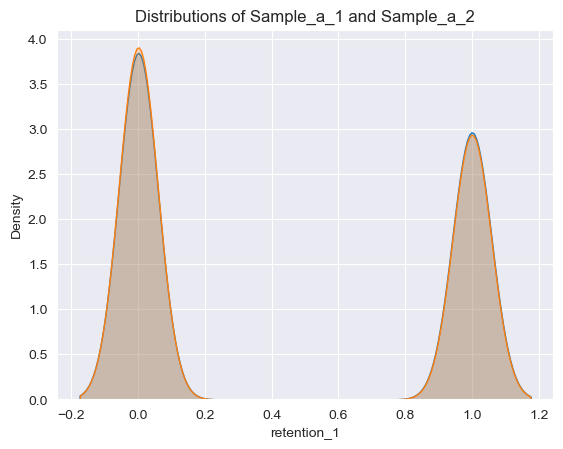

In [ ]:
sns.kdeplot(sample_a_1, fill=True)
sns.kdeplot(sample_b_1, fill=True)
plt.title("Distributions of Sample_a_1 and Sample_a_2")
plt.show()

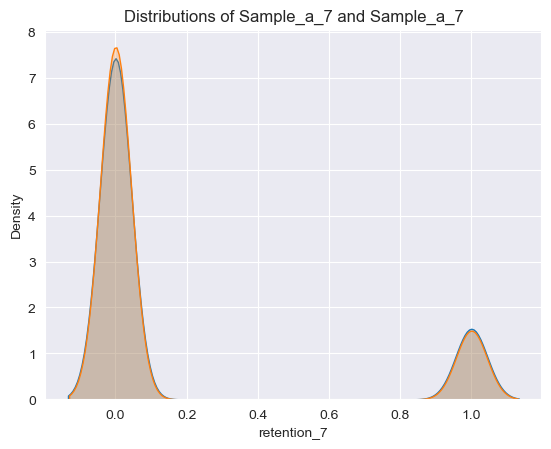

In [ ]:
sns.kdeplot(sample_a_7, fill=True)
sns.kdeplot(sample_b_7, fill=True)
plt.title("Distributions of Sample_a_7 and Sample_a_7")
plt.show()

In [ ]:
#првоерим мощность тестов

alpha = 0.05
p_1 = sample_a_1.sum()/sample_a_1.count()
p_2 = sample_b_1.sum()/sample_b_1.count()
effect_1 = 2 * math.asin(math.sqrt(p_1)) - 2 * math.asin(math.sqrt(p_2))
power = smp.zt_ind_solve_power(effect_size=effect_1, nobs1=len(sample_a_1), alpha=alpha, alternative='two-sided')
power


0.43999433321464065

In [ ]:
alpha = 0.05
p_1 = sample_a_7.sum()/sample_a_7.count()
p_2 = sample_b_7.sum()/sample_b_7.count()
effect = 2 * math.asin(math.sqrt(p_1)) - 2 * math.asin(math.sqrt(p_2))
power = smp.zt_ind_solve_power(effect_size=effect, nobs1=len(sample_a_7), alpha=alpha, alternative='two-sided')
power


0.9015326660237867

In [ ]:
#Мощность теста для ретеншн после 1 дня недостаточна, необходимо увеличить размер выборки
size_1 = smp.zt_ind_solve_power(effect_size=effect_1, power=0.80, alpha=alpha, alternative='two-sided')
print(f'Необходимый размер выборки {round(size_1)}')

Необходимый размер выборки 104522
